In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle

import pyqubo

In [2]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_10.pkl')

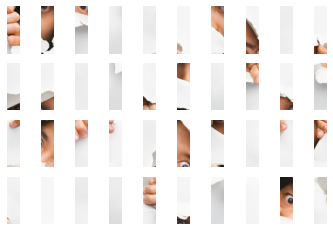

In [3]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [4]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()


print(sim_x(data.images[0], data.images[1]))
print(sim_y(data.images[0], data.images[1]))

7
0


In [5]:
def build_model(data, c=1):
    x = pyqubo.Array.create('x', shape=(data.size, data.rows, data.cols), vartype='BINARY')

    cost = 0
    sim = np.zeros((2, data.size, data.size))
    for a in range(data.size):
        for b in range(data.size):
            if a == b:
                continue
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        s = sim_y(data.images[a], data.images[b])
                        if s != 0:
                            cost -= s*x[a, row, col]*x[b, row + 1, col]
                            sim[0, a, b] = s
                    if col < data.cols - 1:
                        s = sim_x(data.images[a], data.images[b])
                        if s != 0:
                            cost -= s*x[a, row, col]*x[b, row, col + 1]
                            sim[1, a, b] = s

    constraint_coeff = c*2*(sim[0].max() + sim[1].max())
    for a in range(data.size):
        cost += constraint_coeff*pyqubo.Constraint((np.sum(x[a]) - 1)**2, f'img_{a}')
    for row in range(data.rows):
        for col in range(data.cols):
            cost += constraint_coeff*pyqubo.Constraint((np.sum(x[:, row, col]) - 1)**2, f'pos_{row}_{col}')

    return cost.compile(), x

model, x = build_model(data)

In [6]:
bqm = model.to_bqm()

In [7]:
import neal

sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

cost: -1705.0


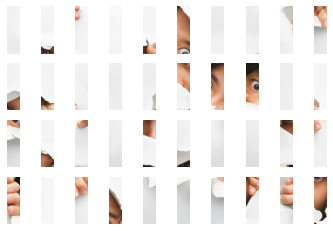

In [8]:
def is_feasible(sample):
    return all(v[0] for v in sample.constraints().values())

def show_solution(sample, data, x):
    values = np.vectorize(lambda x: sample[x.label])(x)
    pos = np.array(np.where(values == 1)).T
    images = [
        data.images[p[0]]
        for p in sorted(pos, key=lambda x: [x[1], x[2]])
    ]
    show(images, data.rows, data.cols)

assert is_feasible(best_sample)
print(f'cost: {best_sample.energy}')
show_solution(best_sample.sample, data, x)